# From EDA to the Top (LB 0.367) by Beluga _1

[원작자](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367)

# 들어가며
이 대회에서 우리는 뉴욕에서 **총 택시 운행시간**을 예측하는 모델을 만듭니다. 몇 개의 EDA 커널이 있고 그 중 몇몇은 훌륭합니다. 제가 여기서 주목할 것은 `특징 추출`입니다. 이 커널에서 몇 개의 캐글 팁과 모델 개선점을 얻을 수 있습니다.  

**주 목표는 제한된 커널에서 최적의 XGB 피쳐 세트를 만드는 것입니다.**      

제 최고 싱글 모델은 LB 0.371이고 여러 모델의 선형 조합은 LB0.368를 줍니다. 한계 개선을 쌓는 것은 0.367입니다.    

아래의 노트북의 개략적인 개요입니다. 
* Explore the dataset
* Extract 59 useful features
* Create simple 80-20 train-validation set
* Train XGBregressor 
* Analyze Feature Importnace
* Score test set and submit 
* Check XGB parameter search result for further improvements 

**References**
* I used a few feature extraction ideas from Nir Malbin's [Kernel](https://www.kaggle.com/donniedarko/darktaxi-tripdurationprediction-lb-0-385)     

In [1]:
%matplotlib inline 
import numpy as np #linear algebra 
import pandas as pd # data processing , CSV file
from datetime import timedelta
import datetime as dt 
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [16,10]
import seaborn as sns  
import xgboost as xgb 

from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA 
from sklearn.cluster import MiniBatchKMeans 

import warnings 
warnings.filterwarnings('ignore')

# First week progress 

In [2]:
beluga = pd.DataFrame({'since_start_hour': [8.0, 8.0, 20.0, 28.0, 37.0, 45.0, 85.0, 85.0, 100.0, 134.0, 134.0, 143.0, 148.0],
                       'Score': [ 0.400,  0.398,  0.393,  0.390,  0.383,  0.380,  0.379,  0.377,  0.376,  0.376,  0.375,  0.371,  0.368]})
others = pd.DataFrame({'since_start_hour': [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,68,69,70,71,72,73,74,75,76,77,78,79,80,81,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148],
                        'BestScore': [.452,.452,.452,.452,.452,.452,.421,.421,.421,.406,.398,.398,.398,.398,.394,.394,.394,.394,.391,.391,.390,.390,.390,.390,.389,.389,.389,.389,.389,.389,.389,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.383,.383,.383,.383,.383,.383,.383,.383,.383,.383,.383,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.373,.373,.373]})

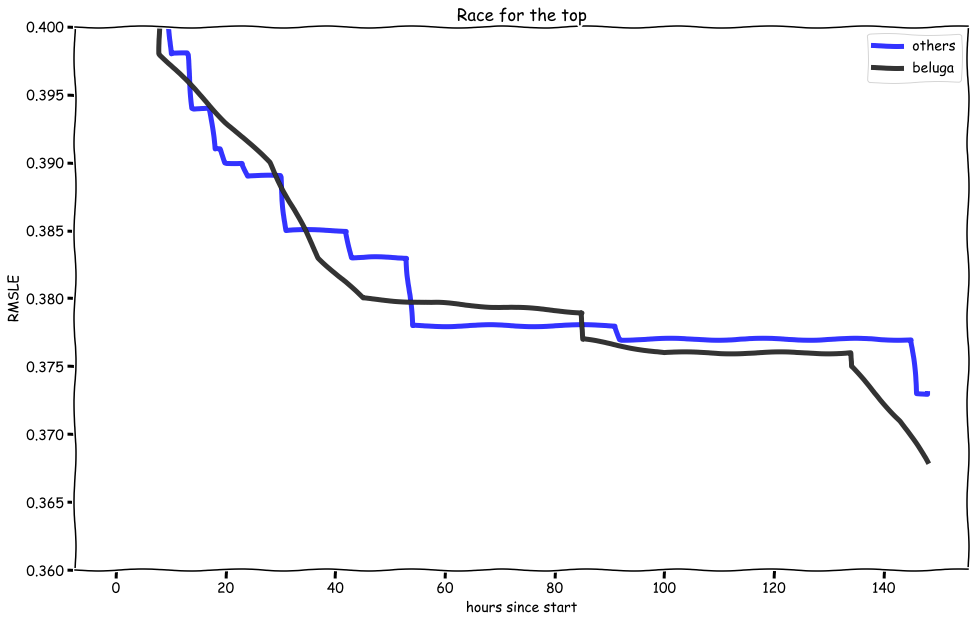

In [3]:
with plt.xkcd():
    #XKCD 스타일
    fig, ax = plt.subplots()
    ax.plot(others.since_start_hour.values, others.BestScore.values,
           'b',alpha = 0.8, lw = 5, label ='others')
    ax.plot(beluga.since_start_hour.values, beluga.Score.values,
           'k',alpha=0.8, lw = 5, label = 'beluga')
    ax.set_ylim(0.36,0.4)
    ax.legend(loc=0)
    ax.set_xlabel('hours since start')
    ax.set_ylabel('RMSLE')
    ax.set_title('Race for the top')
    plt.show()

# Data understanding 

In [4]:
np.random.seed(1987)
N = 100000 # 플랏에서 샘플 행의 갯수 
t0 = dt.datetime.now()
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_sumbission = pd.read_csv('../data/sample_submission.csv')

데이터 파일을 확인해보자. 데이터 설명에 따르면, 컬럼들은 다음과 같다 :
* `id` - 각각 여행에 관해 유니크한 구분자
* `vendor_id` - 여행 기록과 관련된 공급자를 나타내는 코드
* `pickup_datetime` - 미터가 연결되었을 때 날짜와 시간(미터기 켰을 때)
* `dropoff_datetime` - 미터기가 꺼졌을 때 날짜와 시간
* `passenger_count` - 차량에 탑승 한 승객 수 (운전자가 입력 한 값)  
* `pickup_longitude` - 미터기 켜젔을 때 경도
* `pickup_latitue` - 미터기 켜졌을 때 위도
* `dropoff_longitude` - 미터기 커졌을 때 경도
* `dropoff_latitude` - 미터기 꺼졌을 때 위도
* `store_and_fwd_flag` - 이 플래그는 차량이 서버에 연결되지 않았기 때문에 공급 업체에 보내기 전에 차량 메모리에 여행 기록이 보관되었는지 여부를 나타냅니다 (Y = 저장 및 전달, N = 저장 및 전달 여행 아님).
* `trop_durtaion` - 여행 시간 , 초 

명백하게 `dropoff_datetime`과 `trip_duration`이 학습 세트에서 오직 사용가능해 보인다.     
**trip_duration** 이 예측 target 

In [5]:
print('We have {} training rows and {} test rows.'.format(train.shape[0],test.shape[0]))
print('We have {} training columns and {} test columns.'.format(train.shape[1],test.shape[1]))
train.head()

We have 1458644 training rows and 625134 test rows.
We have 11 training columns and 9 test columns.


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [7]:
print('Id is unique') if train.id.nunique() == train.shape[0] else print('oops')
print('Train and test sets are distinct') if len(np.intersect1d(train.id.values, test.id.values))==0 else print('oops')

Id is unique
Train and test sets are distinct


In [8]:
print('We do not nooed to worry about missing values.') if train.count().min()== train.shape[0] and test.count().min() ==test.shape[0] else print('oops')
print('The store_and_fwd_flag has only two values {}'.format(str(set(train.store_and_fwd_flag.unique())| set(test.store_and_fwd_flag.unique()))))

We do not nooed to worry about missing values.
The store_and_fwd_flag has only two values {'N', 'Y'}


In [9]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:,'pickup_date'] = test['pickup_datetime'].dt.date 

train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

train['store_and_fwd_flag'] = 1* (train.store_and_fwd_flag.values =='Y')
test['store_and_fwd_flag'] = 1* (test.store_and_fwd_flag.values =='Y')

In [10]:
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())

duration_difference = train[np.abs(train['check_trip_duration'].values - train['trip_duration'].values)>1]
print('Trip_duration and datatimes are ok') if len(duration_difference[['pickup_datetime','dropoff_datetime',
                                                                       'trip_duration','check_trip_duration']])==0 else print('Oooops')

Trip_duration and datatimes are ok


In [11]:
train['trip_duration'].max() // 3600  ##3600초는 1시간 

979

`trip_duration`의 최대값이 ~1000 시간인걸 알 수 있습니다.. 다행히 평가 메트릭은 RMSLE이며 RMSE가 아닙니다. 이상값은 덜 문제를 일으킬 것이다. 우리는 타겟 라벨에 대해 로그변환을 취하고 훈련 중 RMSE를 사용합니다.

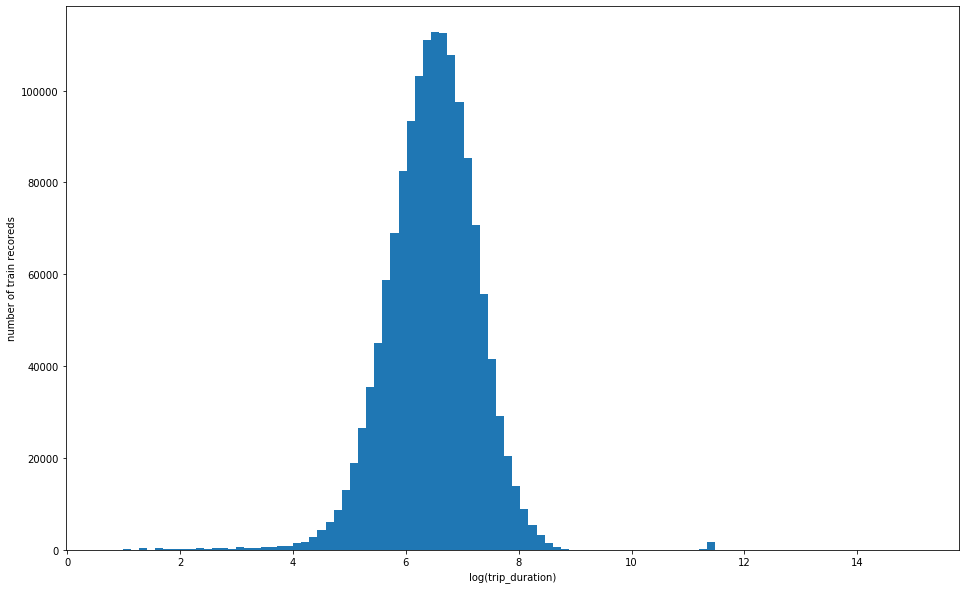

In [12]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)

plt.hist(train['log_trip_duration'].values, bins = 100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train recoreds')
plt.show()

# Validation Strategy 
첫번째로 train test split을 체크합니다. 이것은 검증정략을 결정하도록 도와줄 것이며 피쳐 엔지니어링에 아이디어를 줄것입니다.

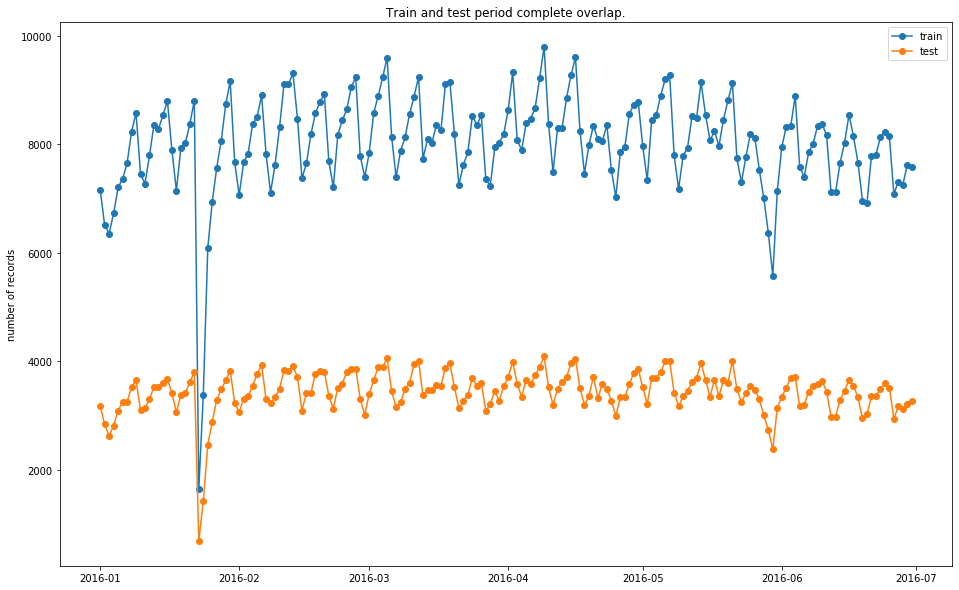

In [13]:
plt.plot(train.groupby('pickup_date').count()[['id']],'o-',label='train')
plt.plot(test.groupby('pickup_date').count()[['id']],'o-',label ='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc = 0)
plt.ylabel('number of records')
plt.show()

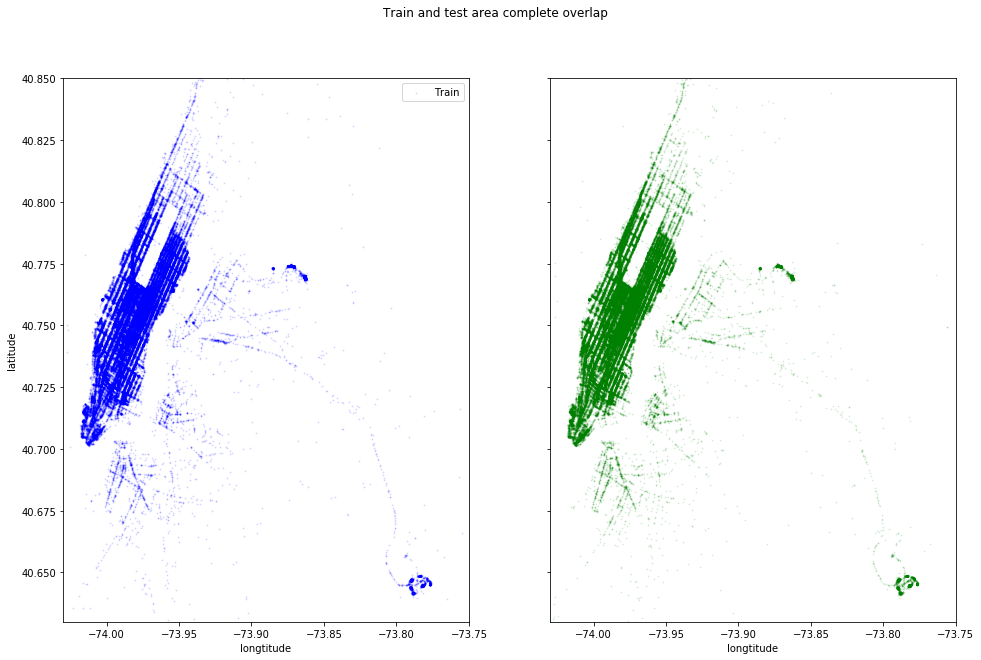

In [14]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig,ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:N],train['pickup_latitude'].values[:N],
             color = 'blue', s =1, label = 'Train', alpha = 0.1)
ax[1].scatter(test['pickup_longitude'].values[:N],test['pickup_latitude'].values[:N],
             color = 'green', s =1, label = 'test', alpha = 0.1)

fig.suptitle('Train and test area complete overlap')
ax[0].legend(loc = 0)
ax[0].set_ylabel('latitude');  ax[0].set_xlabel('longtitude')
ax[1].set_xlabel('longtitude')

plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

이런 경우 학습과 테스트 split이 무작위로 보입니다. 이것은 비지도 학습을 사용하도록 하고 피처 추출을 full data set에 적용합니다.  

# Feature Extraction 

## PCA 
우리는 위도와 경도 좌표를 변환시키기 위해서 PCA를 사용합니다. 이 케이스에서는 차원축소에 대한 것이 아닙니다. 왜냐하면 우리는 2D -> 2D로 변환하기 때문입니다. 회전은ㅇ decision tree splits에 도움을 줄 것입니다. 

In [15]:
coords = np.vstack((train[['pickup_latitude','pickup_longitude']].values,
                   train[['dropoff_latitude','dropoff_longitude']].values,
                   test[['pickup_latitude','pickup_longitude']].values,
                   test[['dropoff_latitude','dropoff_longitude']].values))
pca = PCA().fit(coords)

In [16]:
train['pickup_pca0'] = pca.transform(train[['pickup_latitude','pickup_longitude']])[:,0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude','pickup_longitude']])[:,1]

train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,1]

In [17]:
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]

test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

In [18]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,check_trip_duration,log_trip_duration,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,2016-03-14,455.0,6.122493,0.007691,0.017053,-0.009666,0.013695
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,2016-06-12,663.0,6.498282,0.007677,-0.012371,0.027145,-0.018652
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,2016-01-19,2124.0,7.661527,0.004803,0.012879,0.034222,-0.039337
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,2016-04-06,429.0,6.063785,0.038342,-0.029194,0.041343,-0.042293
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,2016-03-26,435.0,6.077642,-0.002877,0.041749,-0.002380,0.031071


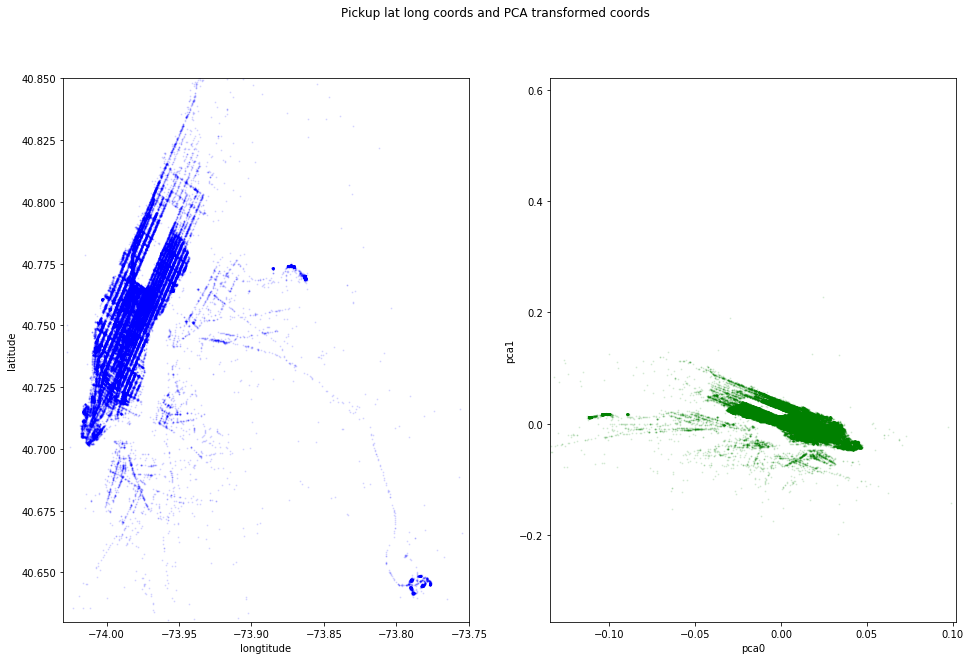

In [19]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N],train['pickup_latitude'].values[:N],
             color= 'blue', s=1, alpha =0.1)
ax[1].scatter(train['pickup_pca0'].values[:N],train['pickup_pca1'].values[:N],
             color= 'green', s=1, alpha =0.1)

fig.suptitle('Pickup lat long coords and PCA transformed coords')
ax[0].set_ylabel('latitude');   ax[0].set_xlabel('longtitude')
ax[0].set_xlim(city_long_border);  ax[0].set_ylim(city_lat_border)
ax[1].set_ylabel('pca1');   ax[1].set_xlabel('pca0')

pca_borders = pca.transform([[x,y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:,0].min(),pca_borders[:,0].max())
ax[1].set_xlim(pca_borders[:,1].min(),pca_borders[:,1].max())
plt.show()

## Distance 
탑승과 하차간 거리를 계산해봅시다. 현재 Haversince가 사용되고 있고 geopy는 다른 계산입니다. 우리는 뉴욕에 있기 때문에 맨하탄 (L1) 거리도 확인합니다.     

pd.DataFrame.apply()는 너무 느려서 haversince 함수가 arrays를 다루기 위해 다시 씌였습니다. 우리는 피처뿐만 아니라 길의 중간도 추출합니다. 

In [20]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians,(lat1,lng1,lat2,lng2))
    AVG_EARTH_RADIUS = 6371 # in km
    lat = lat2 - lat1 
    lng = lng2 - lng1 
    d = np.sin(lat*0.5)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(lng*0.5)**2
    h = 2*AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b  

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371 # in km 
    lng_delta_rad = np.radians(lng2-lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) *np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y,x))

In [21]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, 
                                                     train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, 
                                                                    train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, 
                                          train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

In [22]:
test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, 
                                                    test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, 
                                                                   test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, 
                                         test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

In [23]:
train.loc[:,'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'])/2
train.loc[:,'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'])/2

test.loc[:,'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'])/2
test.loc[:,'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'])/2

## Datetime features 

In [24]:
train.loc[:,'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:,'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear

train.loc[:,'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:,'pickup_minute'] = train['pickup_datetime'].dt.minute

train.loc[:,'pickup_dt'] = (train['pickup_datetime']-train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:,'pickup_week_hour'] = train['pickup_weekday']*24 + train['pickup_hour']

In [25]:
test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

## Speed 

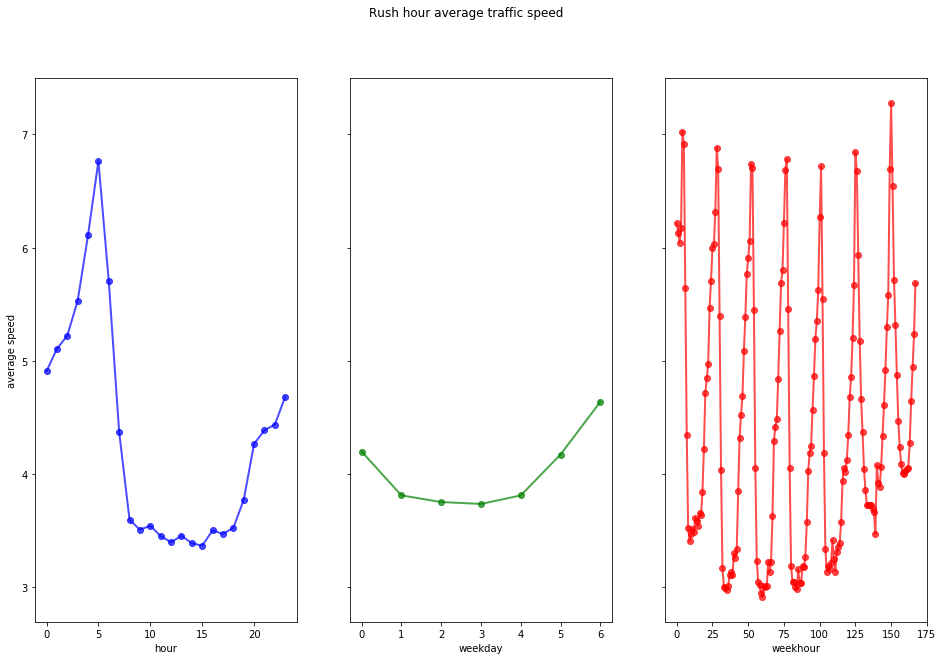

In [26]:
train.loc[:,'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:,'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']

fig, ax = plt.subplots(ncols=3, sharey= True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'],'bo-',lw =2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'],'go-',lw =2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'],'ro-',lw =2, alpha=0.7)

ax[0].set_xlabel('hour');     ax[0].set_ylabel('average speed')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')

fig.suptitle('Rush hour average traffic speed')
plt.show()

In [28]:
train.loc[:,'pickup_lat_bin'] = np.round(train['pickup_latitude'],3)
train.loc[:,'pickup_long_bin'] = np.round(train['pickup_longitude'],3)

# 지역별 평균 speed
gby_cols = ['pickup_lat_bin','pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed,coord_count,on=gby_cols)
coord_stats = coord_stats[coord_stats['id']>100]

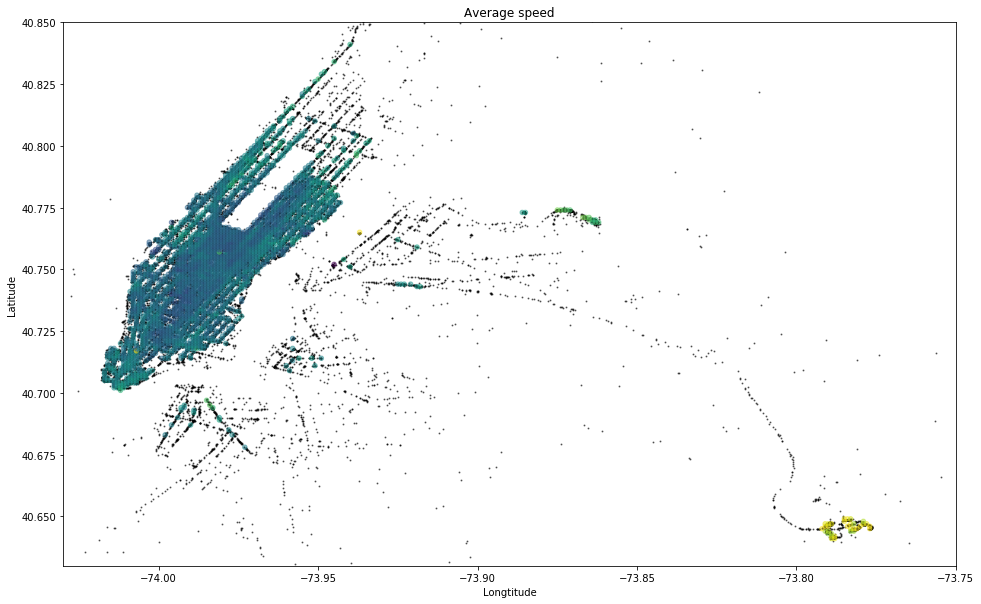

In [29]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N],train.pickup_latitude.values[:N],
          color='black',s=1,alpha = 0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values,
          c = coord_stats.avg_speed_h.values, s = 20, alpha=0.5, vmin=1, vmax = 8)

ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longtitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

In [30]:
train.loc[:,'pickup_lat_bin'] = np.round(train['pickup_latitude'],2)
train.loc[:,'pickup_long_bin'] = np.round(train['pickup_longitude'],2)

train.loc[:,'center_lat_bin'] = np.round(train['center_latitude'],2)
train.loc[:,'center_long_bin'] = np.round(train['center_longitude'],2)

train.loc[:,'pickup_dt_bin'] = (train['pickup_dt']//(3*3600))

In [31]:
test.loc[:, 'pickup_lat_bin'] = np.round(test['pickup_latitude'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['pickup_longitude'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

## Clustering 

In [32]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [33]:
train.loc[:,'pickup_cluster'] = kmeans.predict(train[['pickup_latitude','pickup_longitude']])
train.loc[:,'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude','dropoff_longitude']])

test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

t1 = dt.datetime.now()
print("Time till clustering: %i seconds"%(t1-t0).seconds)

Time till clustering: 90 seconds


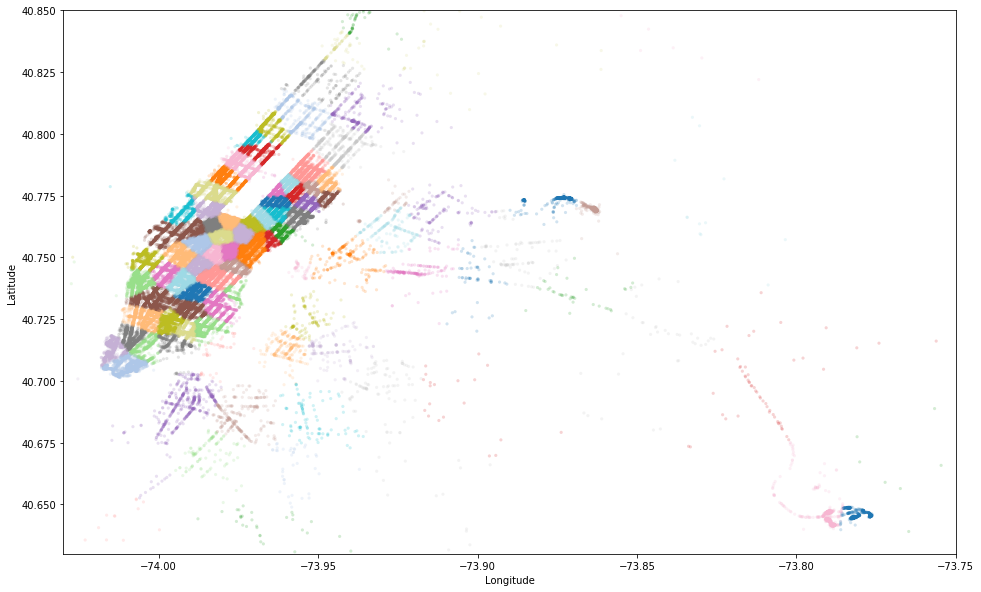

In [34]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N],train.pickup_latitude.values[:N],s=10,lw=0,
          c = train.pickup_cluster[:N].values,cmap='tab20', alpha=0.2)

ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

## Temporal and geospatial aggregation
몇 평균 트래픽 스피드 피쳐를 추가합니다. 만약 학습/테스트 split이 시간 기반이면 시간적 특성을 많이 사용할 수 없습니다. 이 경쟁에서 우리는 미래를 예측할 필요가 없습니다.

In [35]:
for gby_col in ['pickup_hour','pickup_date','pickup_dt_bin',
               'pickup_week_hour','pickup_cluster','dropoff_cluster'] :
    gby = train.groupby(gby_col).mean()[['avg_speed_h','avg_speed_m','log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train = pd.merge(train, gby, how = 'left', left_on = gby_col, right_index= True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)
    

In [36]:
for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

In [37]:
group_freq = '60min'
df_all = pd.concat((train, test))[['id','pickup_datetime','pickup_cluster','dropoff_cluster']]
train.loc[:,'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)

In [38]:
# 60분 이상 여행 횟수 계산
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']

train = train.merge(df_counts,on='id',how = 'left')
test = test.merge(df_counts, on='id', how='left') 

In [40]:
# 시간에 따라 각 클러스터로 향하는 클러스터가 얼마나 많은지 세자
# group_freq = 60min
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
pickup_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby('pickup_cluster').resample(group_freq) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('pickup_cluster').rolling('240min').mean() \
    .drop('pickup_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

In [41]:
# Count how many trips are going from each cluster over time
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
pickup_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby('pickup_cluster').resample(group_freq) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('pickup_cluster').rolling('240min').mean() \
    .drop('pickup_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

In [42]:
train['pickup_cluster_count'] = train[['pickup_datetime_group','pickup_cluster']].merge(pickup_counts, 
                                                                                       on=['pickup_datetime_group','pickup_cluster'],how = 'left')['pickup_cluster_count'].fillna(0)
test['pickup_cluster_count'] = test[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], 
                                                                                       how='left')['pickup_cluster_count'].fillna(0)

## OSRM Features 
이전 버전에서는 대략적인 거리 추정 만있었습니다. 이제 우리는 픽업과 하차 사이의 가장 빠른 경로 거리 추정치를 사용합니다.


In [44]:
fr1 = pd.read_csv('../data/fastest_routes_train_part_1.csv',
                 usecols = ['id','total_distance','total_travel_time','number_of_steps'])
fr2 = pd.read_csv('../data/fastest_routes_train_part_2.csv',
                 usecols=['id','total_distance','total_travel_time','number_of_steps'])
test_street_info = pd.read_csv('../data/fastest_routes_test.csv',
                              usecols=['id','total_distance','total_travel_time','number_of_steps'])

In [45]:
train_street_info = pd.concat((fr1,fr2))
train = train.merge(train_street_info,how = 'left',on='id')
test = test.merge(test_street_info,how='left',on='id')
train_street_info.head()

,id,total_distance,total_travel_time,number_of_steps
0,id2875421,2009.1,164.9,5
1,id2377394,2513.2,332.0,6
2,id3504673,1779.4,235.8,4
3,id2181028,1614.9,140.1,5
4,id0801584,1393.5,189.4,5


In [47]:
feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns))
do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime',
                           'trip_duration', 'check_trip_duration',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m',
                           'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin',
                           'pickup_dt_bin', 'pickup_datetime_group']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]

#print(feature_names)
print('We have %i features'%len(feature_names))
train[feature_names].count()
y = np.log(train['trip_duration'].values+1)

t1 = dt.datetime.now()
print('Feature extraction time : %i secons'%(t1-t0).seconds)

['avg_speed_h' 'avg_speed_m' 'check_trip_duration' 'dropoff_datetime'
 'log_trip_duration' 'trip_duration']
We have 58 features
Feature extraction time : 2090 secons


## Feature check before modeling 
모델링 전에 학습을 확인하고 특성 분포를 테스트하는 것이 골칫거리를 덜어 줄 수 있습니다. 일반적으로 kaggle 대회에서 학습와 테스트 세트는 동일합니다. 학습 세트와 테스트 세트 사이에 큰 차이가 있다면 기능 추출 파이프 라인에 버그가있을 수 있습니다.

In [48]:
feature_stats = pd.DataFrame({'feature': feature_names})
feature_stats.loc[:,'train_mean'] = np.nanmean(train[feature_names].values,axis =0).round(4)
feature_stats.loc[:,'test_mean'] = np.nanmean(test[feature_names].values,axis = 0).round(4)

feature_stats.loc[:, 'train_std'] = np.nanstd(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_std'] = np.nanstd(test[feature_names].values, axis=0).round(4)

feature_stats.loc[:, 'train_nan'] = np.mean(np.isnan(train[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'test_nan'] = np.mean(np.isnan(test[feature_names].values), axis=0).round(3)

feature_stats.loc[:,'train_test_mean_diff'] = np.abs(feature_stats['train_mean']-feature_stats['test_mean']) /np.abs(feature_stats['train_std']+feature_stats['test_std']) *2 
feature_stats.loc[:,'train_test_nan_diff'] = np.abs(feature_stats['train_nan']-feature_stats['test_nan'])

feature_stats = feature_stats.sort_values(by = 'train_test_mean_diff')

feature_stats[['feature','train_test_mean_diff']].tail()

,feature,train_test_mean_diff
21,pickup_dt,0.002648
48,cnt_pickup_hour_pickup_cluster,0.002718
7,pickup_pca0,0.002774
10,dropoff_pca1,0.002833
18,pickup_hour_weekofyear,0.002872


In [49]:
feature_stats = feature_stats.sort_values(by = 'train_test_nan_diff')
feature_stats[['feature','train_nan','test_nan','train_test_nan_diff']].tail()

,feature,train_nan,test_nan,train_test_nan_diff
22,pickup_week_hour,0.000,0.000,0.000
19,pickup_hour,0.000,0.000,0.000
18,pickup_hour_weekofyear,0.000,0.000,0.000
52,cnt_pickup_cluster_dropoff_cluster,0.105,0.107,0.002
51,avg_speed_h_pickup_cluster_dropoff_cluster,0.105,0.107,0.002


최상위 평균 차이조차도 표준 편차의 1 % 미만입니다. 누락 된 값이 몇 개 있지만 누락 된 비율은 동일합니다. 다행히 xgboost는 누락 된 값을 처리 할 수 ​​있습니다.

# Modeling 

In [50]:
Xtr, Xv, ytr,  yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state = 1987)
dtrain = xgb.DMatrix(Xtr, label= ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist =[(dtrain,'train'),(dvalid,'valid')]

In [51]:
# 다른거 해봐도 좋은데 이건 글쓴이 페이브릿
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [52]:
# 더 해봐도 ok
model = xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50,
                 maximize=False, verbose_eval=10)

[0]	train-rmse:4.22552	valid-rmse:4.22677
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.400824	valid-rmse:0.416053
[20]	train-rmse:0.368522	valid-rmse:0.390442
[30]	train-rmse:0.360587	valid-rmse:0.387556
[40]	train-rmse:0.356414	valid-rmse:0.38618
[50]	train-rmse:0.352051	valid-rmse:0.385544
[59]	train-rmse:0.348814	valid-rmse:0.384782


In [54]:
print('Modeling RMSLE %.5f' %model.best_score)
t1 = dt.datetime.now()
print('Training time : %i seconds' %(t1-t0).seconds)

Modeling RMSLE 0.38478
Training time : 2955 seconds


# Feature importance analysis 
Xgboost 모델에는 자주 사용되는 기능 중요도 점수가 있습니다. 꼭 필요하지 않다는 것은 기능이 정말 중요하다는 것을 의미하고, 높은 점수는 기능이 더 많은 트리 분할에서 사용되었음을 의미합니다. 상관 관계가 높거나 카디널리티가 높은 기능은 결과를 편향시킵니다.   
I tried a simple backward feature elimination round. For each feature a new model was trained without that feature. It helps to understand what are the essential features which we should not remove. Since it would take a few hours to train 56 models I use my offline validation result.

_Please note the OSRM features were added later so they are not included in the following section. Trust me they are important ;)_

In [61]:
rmse_wo_feature = [0.39224, 0.38816, 0.38726, 0.38780, 0.38773, 0.38792, 0.38753, 0.38745, 0.38710, 0.38767, 0.38738, 0.38750, 0.38678, 0.39359, 0.38672, 0.38794, 0.38694, 0.38750, 0.38742, 0.38673, 0.38754,
                   0.38705, 0.38736, 0.38741, 0.38764, 0.38730, 0.38676, 0.38696, 0.38750, 0.38705, 0.38746, 0.38727, 0.38750, 0.38771, 0.38747, 0.38907, 0.38719, 0.38756, 0.38701, 0.38734, 0.38782, 0.38673, 
                   0.38797, 0.38720, 0.38709, 0.38704, 0.38809, 0.38768, 0.38798, 0.38849, 0.38690, 0.38753, 0.38721, 0.38807, 0.38830, 0.38750, np.nan, np.nan]

In [62]:
len(rmse_wo_feature)

58

In [63]:
len(feature_names)

58

In [65]:
feature_importance_dict = model.get_fscore()
fs = ['f%i'% i for i in range(len(feature_names))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()),
                  'importance':list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 'feature_name': feature_names,
                  'rmse_wo_feature': rmse_wo_feature})

feature_importance = pd.merge(f1, f2,how='right',on='f')
feature_importance = feature_importance.fillna(0)

feature_importance[['feature_name','importance','rmse_wo_feature']].sort_values(by='importance',ascending = False)

,feature_name,importance,rmse_wo_feature
0,total_distance,906,0.38750
17,center_longitude,844,0.38694
16,center_latitude,762,0.38794
22,direction,753,0.39359
43,distance_dummy_manhattan,681,0.38678
38,distance_haversine,676,0.38750
51,dropoff_pca1,670,0.38738
44,total_travel_time,653,0.00000
5,dropoff_latitude,636,0.38792
31,pickup_pca1,623,0.38710


다음 plot 결과가 피처 제거 결과와 xgbosst의 중요도를 보여줄 것입니다. 몇가지 관찰 결과는 다음과 같습니다. :
* 기능 중요도 점수가 높은 위치 관련 기능이 꽤 많았지 만 그중 하나만 제거해도 오류가 실제로 증가하지는 않습니다. 
* `Vendor_id`는 기능 중요도 플롯에 따라 두 번째로 적게 사용되는 기능이지만 제거하면 rmse가 크게 증가합니다. 이진 값이며이를 사용하는 몇 개의 의사 결정 트리도 정보를 캡처합니다. 
* 방향은 두 측면에서 중요합니다. 상호 관련된 기능이 많지 않으며 제거하면 모델이 손상됩니다. 
* 모델을 부러뜨리지 않고 제거 할 수있는 다양한 기능이 있습니다(?)        

실제 프로젝트에서는 더 적은 변수가 있는 모델을 선호하지만 캐글 경연대회에서는 _I err on having more even if they only give marginal improvent._

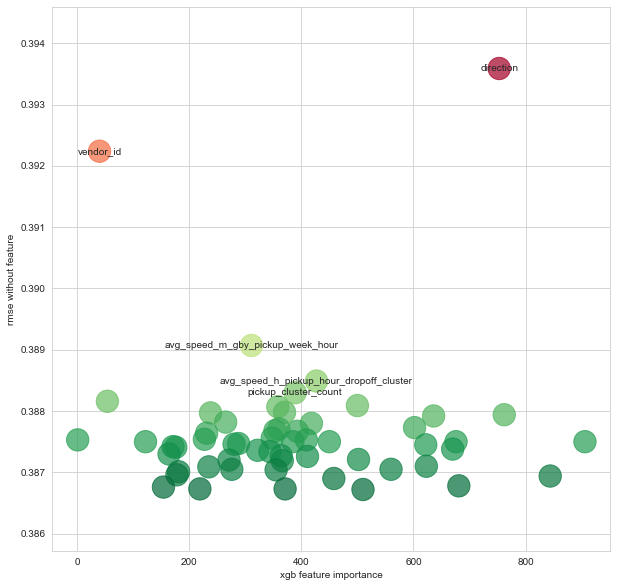

In [69]:
feature_importance = feature_importance.sort_values(by = 'rmse_wo_feature',ascending=False)
feature_importance = feature_importance[feature_importance['rmse_wo_feature']>0]

with sns.axes_style('whitegrid') :
    fig, ax = plt.subplots(figsize = (10,10))
    ax.scatter(feature_importance['importance'].values,
              feature_importance['rmse_wo_feature'].values,
              c = feature_importance['rmse_wo_feature'].values,
              s = 500, cmap = 'RdYlGn_r', alpha = 0.7)
    for _, row in feature_importance.head(5).iterrows():
        ax.text(row['importance'],row['rmse_wo_feature'],row['feature_name'],
                verticalalignment='center', horizontalalignment='center')
    ax.set_xlabel('xgb feature importance')
    ax.set_ylabel('rmse without feature')
    ax.set_ylim(np.min(feature_importance['rmse_wo_feature'])-0.001,
               np.max(feature_importance['rmse_wo_feature'])+0.001)
    plt.show()

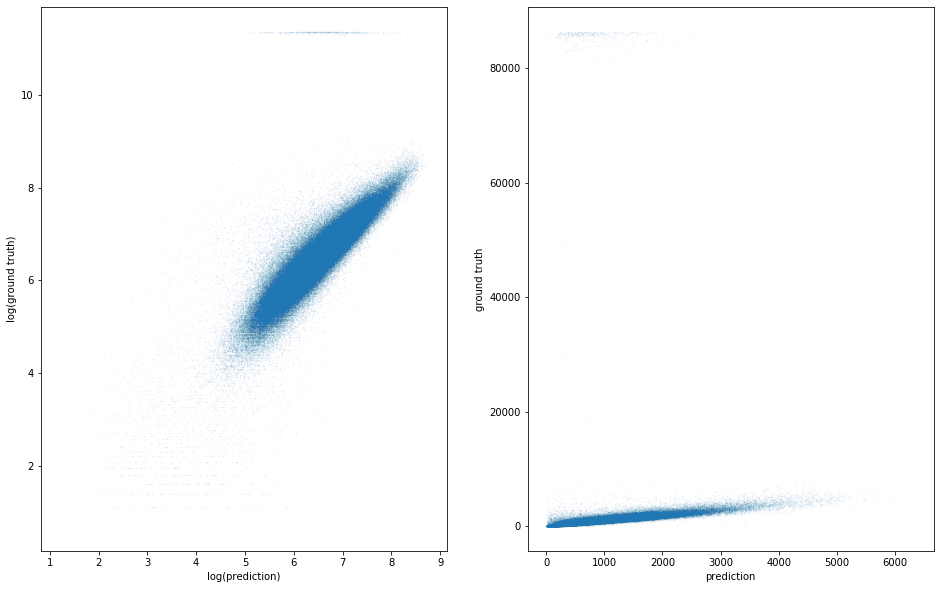

In [70]:
ypred = model.predict(dvalid)

fig,ax = plt.subplots(ncols=2)
ax[0].scatter(ypred, yv, s=0.1, alpha = 0.1)
ax[0].set_xlabel('log(prediction)')
ax[0].set_ylabel('log(ground truth)')

ax[1].scatter(np.exp(ypred), np.exp(yv), s=0.1, alpha=0.1)
ax[1].set_xlabel('prediction')
ax[1].set_ylabel('ground truth')
plt.show()

# Submission
로그 기간을 다시 변환하고 제출 파일을 저장해야합니다.

대부분의 경우 5 개의 일일 제출 슬롯은 실험을 로컬에서 검증 할 수 있기 때문에 충분해야합니다. 팀에서 일하고 있거나 경쟁이 거의 끝나가는 경우 제출하기 전에 버그를 피하고 싶습니다. 여기서 우리는 유효한 예측 분포를 확인합니다. `iid split`로 인해 동일하게 보일 것입니다. 이전 제출물과의 상관 관계를 확인하면 더 많은 자신감을 얻을 수 있습니다.

In [72]:
ytest = model.predict(dtest)
print('Test shape Ok') if test.shape[0] == ytest.shape[0] else print('No')

test['trip_duration'] = np.exp(ytest) - 1
test[['id','trip_duration']].to_csv('beluga_xgb_submission.csv.gz',index = False, compression='gzip')

print('Valid prediction mean: %.3f' % ypred.mean())
print('Test prediction mean: %.3f' % ytest.mean())

Test shape Ok
Valid prediction mean: 6.467
Test prediction mean: 6.466


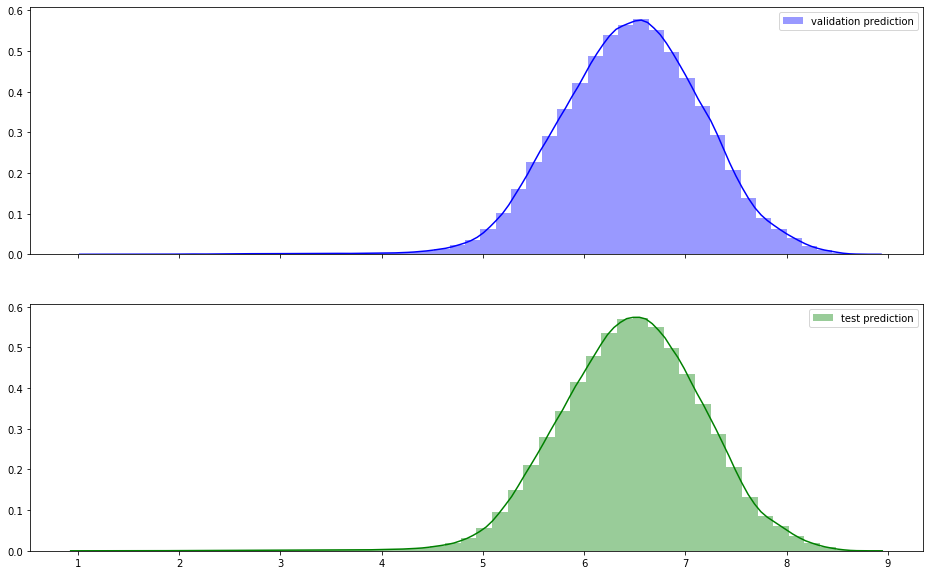

Total time: 4462 seconds


In [73]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(ypred,ax=ax[0],color='blue', label='validation prediction')
sns.distplot(ytest, ax=ax[1],color='green',label = 'test prediction')

ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()

t1 = dt.datetime.now()
print('Total time: {} seconds'.format((t1-t0).seconds))

The distributions look like identical. We are ready for submission.

# XGB Parameter Seach Result 
파라미터 튜닝은 저는 랜덤 서치를 선호합니다. 일반적으로 다음 매개 변수에 대해 다른 값을 시도합니다.:     
* min_child_weight
* eta
* colsample_bytree
* max_depth
* subsample
* lambda    

저는 `sklearn CV` 옵션(RandomizedSearchCV or GridSearchCV)을 좋아하지만 보통 경연대회에서는 싱글 모델 학습은 여러 시간이 걸리고 저는 중간 결과(performance metric, oof predictions etc.) 를 저장하는 걸 좋아합니다. 결과를 바탕으로 `grid searchpoing`를 설정합니다. 

In [74]:
xgb_pars = []
for MCW in [10, 20, 50, 75, 100]:
    for ETA in [0.05, 0.1, 0.15]:
        for CS in [0.3, 0.4, 0.5]:
            for MD in [6, 8, 10, 12, 15]:
                for SS in [0.5, 0.6, 0.7, 0.8, 0.9]:
                    for LAMBDA in [0.5, 1., 1.5,  2., 3.]:
                        xgb_pars.append({'min_child_weight': MCW, 'eta': ETA, 
                                         'colsample_bytree': CS, 'max_depth': MD,
                                         'subsample': SS, 'lambda': LAMBDA, 
                                         'nthread': -1, 'booster' : 'gbtree', 'eval_metric': 'rmse',
                                         'silent': 1, 'objective': 'reg:linear'})

In [76]:
FOREVER_COMPUTING_FLAG = False

while FOREVER_COMPUTING_FLAG :
    xgb_par = np.random.choice(xgb_pars,1)[0]
    print(xgb_par)
    model = xgb.train(xgb_par, dtrain, 2000, watchlist,
                     early_stopping_rounds=50, 
                     maximize=False, verbose_eval=100)
    print('Modeling RMSEL{}'.format(model.best_score))

이러한 실험은 커널 제한보다 훨씬 많은 시간이 소요되므로 결과의 하위 집합이 여기에 복사됩니다.

In [77]:
paropt = pd.DataFrame({'lambda':[1.5,1.0,1.0,1.5,1.5,1.0,1.5,1.0,1.5,2.0,0.5,1.0,0.5,1.5,1.5,0.5,1.0,1.5,0.5,2.0,1.0,2.0,2.0,1.5,1.5,2.0,1.5,2.0,1.5,0.5,1.0,1.0,2.0,1.5,1.0,1.0,0.5,2.0,1.0,0.5,0.5,2.0,1.0,1.0,0.5,0.5,1.5,0.5,1.5,2.0,2.0,2.0,2.0,0.5,1.5,1.0,1.5,2.0,2.0,0.5,1.5,1.0,0.5,1.0,1.5,2.0,1.0,1.0,2.0,2.0,1.0,0.5,0.5,1.0,1.5,2.0,0.5,1.0,1.5,1.0,1.0,1.5,1.5,1.5,0.5,1.5,1.0,1.5,2.0,2.0,2.0,1.0,2.0,0.5,2.0,0.5,1.5,0.5,2.0,0.5,1.0,1.5,1.5,1.5,2.0,0.5,0.5,1.0,2.0],
                       'eta':[.1,.1,.05,.05,.05,.15,.15,.1,.1,.05,.15,.15,.15,.1,.1,.1,.1,.05,.15,.05,.05,.05,.15,.15,.05,.05,.05,.05,.15,.15,.15,.15,.1,.05,.05,.1,.1,.1,.1,.1,.05,.15,.15,.15,.1,.1,.05,.05,.15,.15,.15,.1,.1,.05,.05,.05,.05,.05,.15,.1,.1,.15,.1,.1,.05,.15,.15,.15,.1,.05,.05,.05,.05,.15,.1,.1,.1,.1,.05,.05,.05,.15,.15,.1,.1,.1,.1,.05,.15,.15,.1,.1,.1,.05,.05,.1,.1,.1,.1,.1,.05,.15,.15,.15,.15,.05,.05,.15,.15],
                       'min_child_weight': [50,50,20,100,10,50,100,100,75,10,10,50,50,100,75,100,50,10,20,10,75,20,50,75,100,100,10,20,75,75,75,20,10,75,10,100,100,10,20,20,50,50,100,20,50,100,100,75,20,75,20,50,20,10,20,20,20,75,20,75,100,10,10,20,10,20,100,75,75,10,100,50,100,100,50,10,75,75,50,10,75,75,50,75,20,100,100,50,20,20,50,50,75,20,50,100,75,75,100,75,10,10,20,20,10,10,75,50,20],
                       'subsample':[.8,.9,.8,.6,.6,.6,.9,.6,.5,.9,.8,.9,.7,.5,.5,.9,.7,.7,.5,.8,.5,.9,.6,.6,.8,.8,.8,.7,.5,.5,.9,.9,.5,.6,.7,.8,.8,.6,.9,.7,.8,.6,.6,.9,.7,.7,.8,.6,.6,.5,.9,.8,.7,.6,.6,.6,.5,.9,.8,.5,.7,.6,.8,.6,.8,.8,.6,.7,.9,.5,.7,.5,.9,.7,.8,.9,.9,.7,.8,.5,.7,.8,.6,.8,.8,.5,.9,.5,.5,.7,.8,.6,.6,.8,.7,.6,.6,.6,.7,.7,.8,.6,.5,.9,.7,.6,.9,.5,.5],
                       'rmse': [.380,.380,.377,.378,.378,.386,.382,.382,.383,.374,.386,.381,.385,.383,.383,.379,.381,.376,.389,.375,.381,.374,.385,.385,.378,.377,.375,.376,.385,.386,.382,.384,.384,.379,.376,.380,.380,.382,.380,.382,.378,.385,.384,.383,.383,.383,.379,.381,.386,.387,.381,.380,.380,.377,.377,.377,.379,.376,.382,.385,.382,.386,.380,.382,.375,.383,.385,.384,.379,.378,.380,.381,.378,.384,.380,.377,.379,.383,.380,.380,.380,.383,.385,.381,.379,.386,.380,.383,.387,.383,.382,.384,.385,.377,.380,.383,.383,.383,.382,.382,.377,.386,.388,.382,.384,.379,.378,.387,.388]
                       })

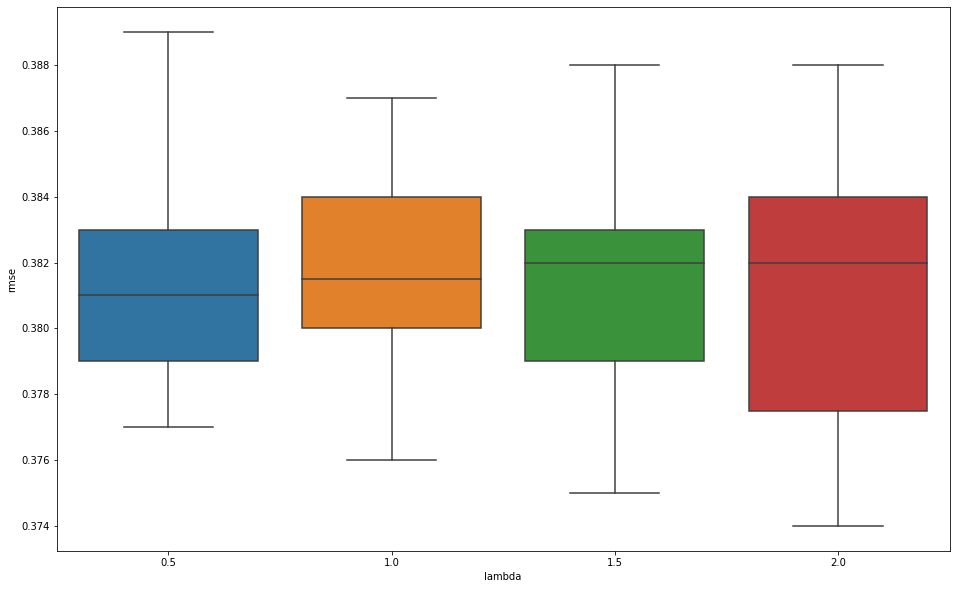

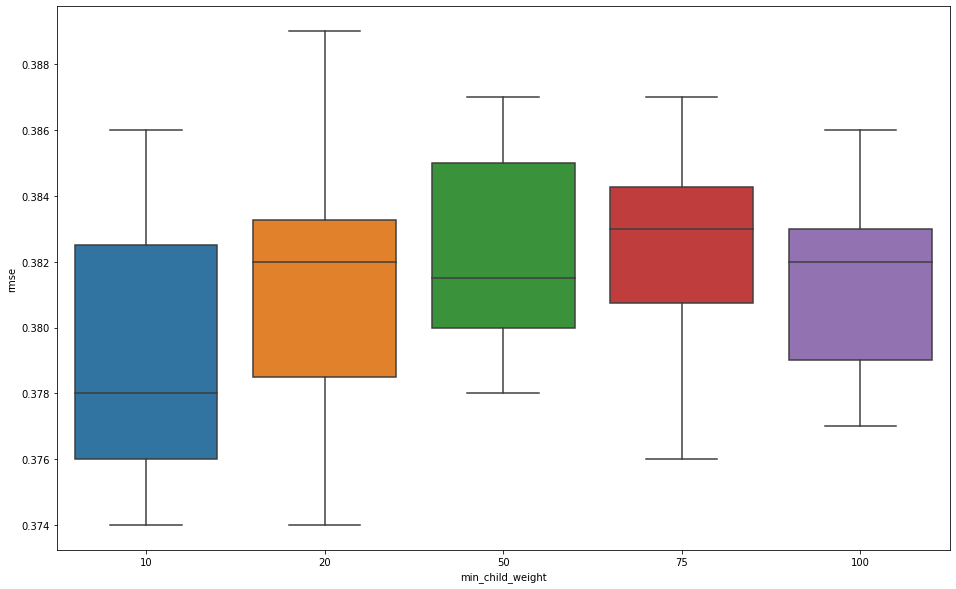

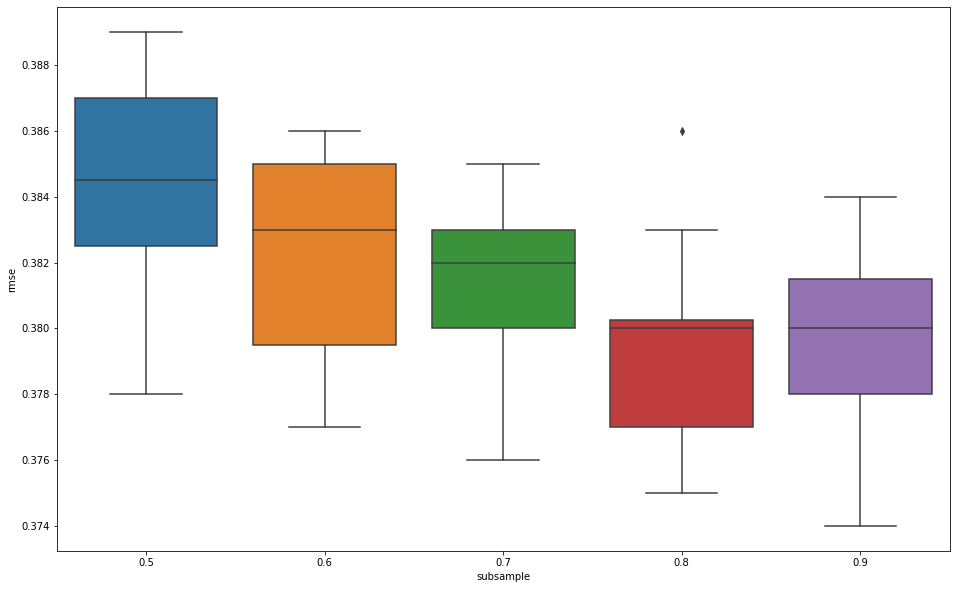

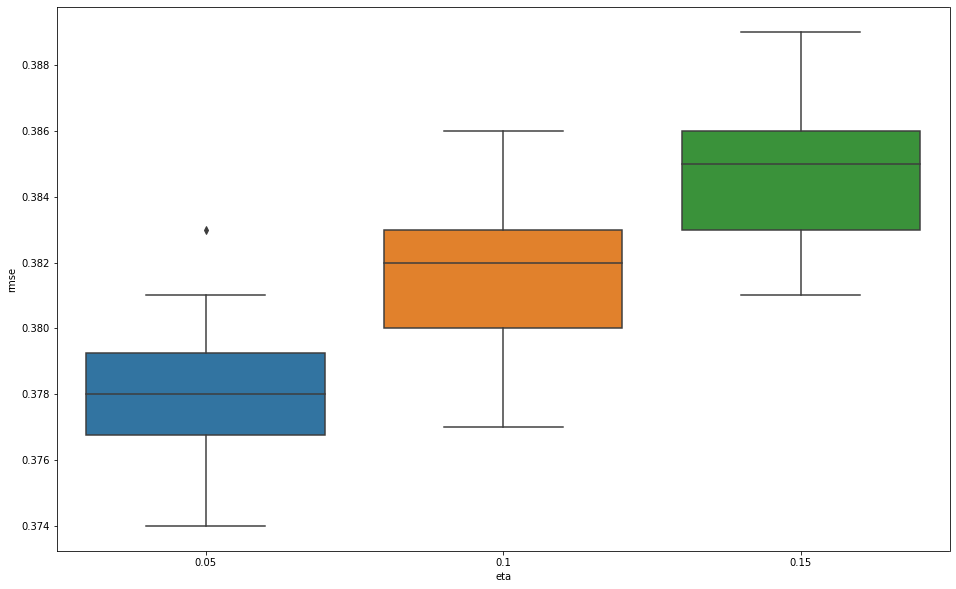

In [79]:
for i, par in enumerate(['lambda','min_child_weight','subsample','eta']) :
    fig, ax = plt.subplots()
    ax = sns.boxplot(x = par, y = 'rmse',data = paropt)

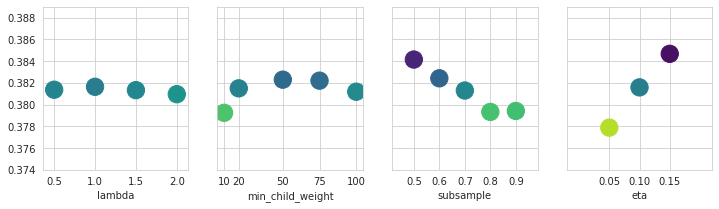

In [80]:
with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(ncols=4, sharey=True, figsize=(12, 3))
    for i, par in enumerate(['lambda', 'min_child_weight', 'subsample', 'eta']):
        mean_rmse = paropt.groupby(par).mean()[['rmse']].reset_index()
        axs[i].scatter(mean_rmse[par].values, mean_rmse['rmse'].values, c=mean_rmse['rmse'].values,
                       s=300, cmap='viridis_r', vmin=.377, vmax=.385, )
        axs[i].set_xlabel(par)
        axs[i].set_xticks(mean_rmse[par].values)
        axs[i].set_ylim(paropt.rmse.min(), paropt.rmse.max())

낮은 eta가 성능을 크게 향상시킬 수 있음을 알 수 있습니다. 더 높은 하위 샘플과 더 작은 하위 제한은 더 나은 결과로 이어집니다.    **Lambda**는 실제로 중요하지 않습니다.

# Cross Validastion test 
우리는 LB 제출보다 학습 검증에서 더 낮은 (더 나은) RMSLE을 보았습니다. 모든 제출물을 확인할 수 있습니다

In [81]:
cv_lb = pd.DataFrame({'cv': [0.3604,0.36056,0.3614,0.3618,0.3623,0.3626,0.3646,0.3696,0.3702,0.3706,0.372,0.3738,0.37477,0.37691,0.3824,0.3868,0.3904],
                      'lb': [0.367,0.367,0.368,0.368,0.368,0.368,0.371,0.375,0.376,0.376,0.377,0.377,0.379,0.381,0.387,0.39,0.393]})

CV - LB Diff:0.005109411764705885


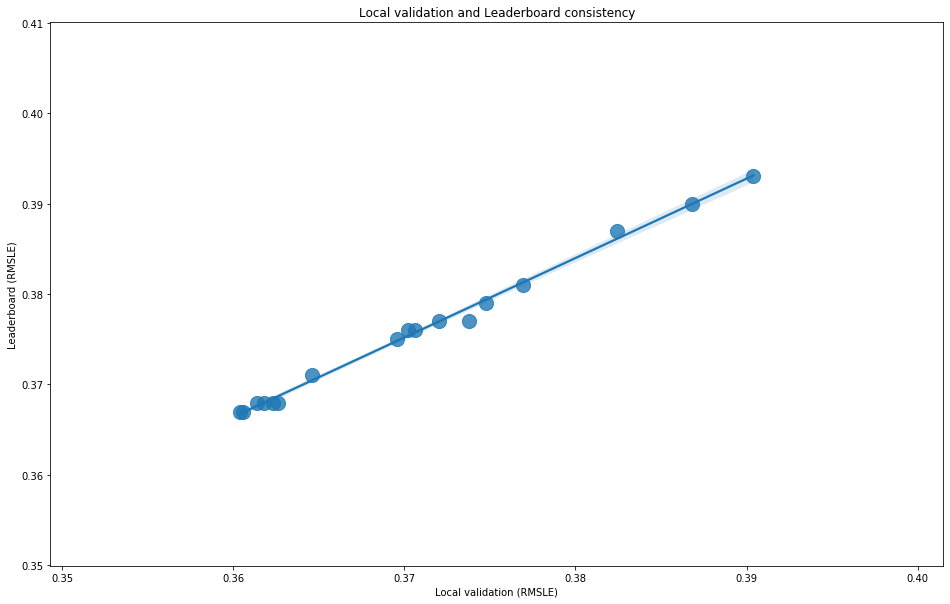

In [83]:
ax = sns.regplot(x='cv',y ='lb',data=cv_lb, scatter_kws={'s':200})

ax.set_xlabel('Local validation (RMSLE)')
ax.set_ylabel('Leaderboard (RMSLE)')
ax.set_title('Local validation and Leaderboard consistency')

print('CV - LB Diff:{}'.format(np.mean(cv_lb['lb']-cv_lb['cv'])))

로컬 유효성 검사 점수가 일반적으로 더 낮다는 것을 알 수 있습니다 (~ 0.005). 일관된 차이는 대부분의 캐글 대회에서 문제가되지 않지만, 차이가 증가하기 시작하면 훈련 파이프 라인에서 누출이나 과적합의 원인을 찾아야합니다.